# Univariate ARIMA Benchmark

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
inflation = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='1.Inflation')
inflation

,HICPxEN_SA,HICPxENFOOD_SA
NaT,NaN,NaN
1999-03-31,89.14290,90.10781
1999-06-30,89.26107,90.24440
1999-09-30,89.45457,90.60880
1999-12-31,89.67210,90.66729
...,...,...
2017-03-31,117.96370,115.54440
2017-06-30,118.33870,116.00980
2017-09-30,118.70470,116.36170
2017-12-31,118.95130,116.36400


In [3]:
inflation = inflation.iloc[1:-1,:]
inflation = inflation[['HICPxEN_SA']]
inflation['Log_CPI'] = np.log(inflation['HICPxEN_SA'])
inflation['y'] = inflation['Log_CPI'].diff()
inflation = inflation.rename(columns={'index':'date'})
inflation = inflation.drop(columns=['HICPxEN_SA', 'Log_CPI'])
inflation

,y
1999-03-31,NaN
1999-06-30,0.001325
1999-09-30,0.002165
1999-12-31,0.002429
2000-03-31,0.002381
...,...
2016-12-31,0.002216
2017-03-31,0.003705
2017-06-30,0.003174
2017-09-30,0.003088


In [4]:
inflation = inflation.iloc[1:,:]
inflation

,y
1999-06-30,0.001325
1999-09-30,0.002165
1999-12-31,0.002429
2000-03-31,0.002381
2000-06-30,0.001865
...,...
2016-12-31,0.002216
2017-03-31,0.003705
2017-06-30,0.003174
2017-09-30,0.003088


## Inlfation Over Time

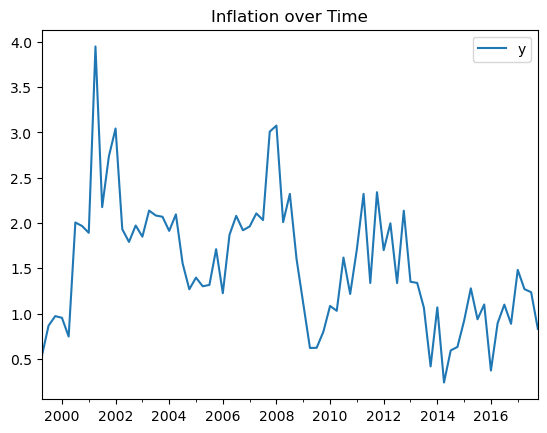

In [5]:
annual_inflation = inflation *400
annual_inflation.plot()
plt.title('Inflation over Time')
plt.show()

## Stationarity Check

In [6]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

check_stationarity(inflation['y'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.161460
p-value                         0.022327
#Lags Used                      3.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


## ACF and PACF Plots

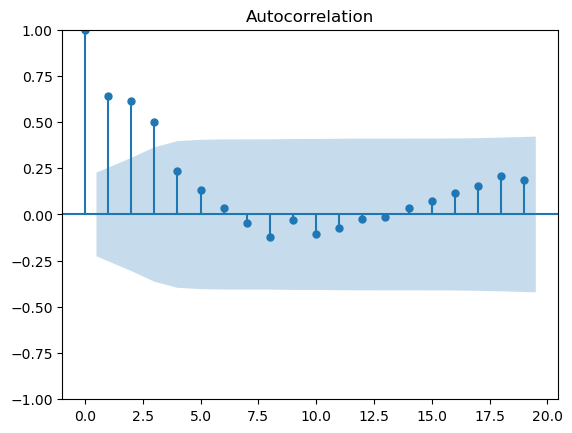

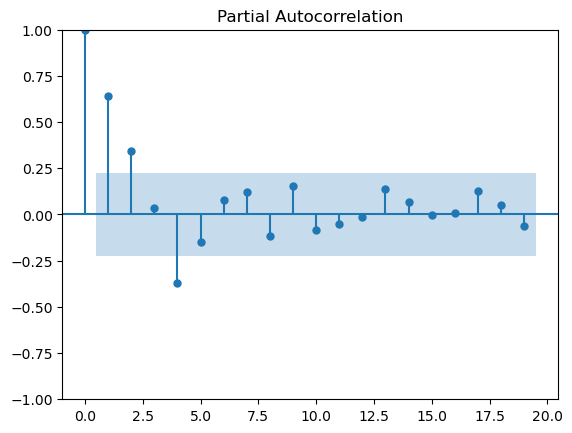

In [7]:
plot_acf(inflation)
plot_pacf(inflation)
plt.show()

### ACF Plot Interpretation:
The ACF plot shows the correlation of the series with itself, lagged by x time units. Here's what we can interpret from the ACF plot provided:

1. The ACF shows a strong correlation at lag 0, which is always the case since the series will be perfectly correlated with itself.
2. The ACF tails off slowly, suggesting a non-stationary process which is typical for data that needs differencing.
3. Significant autocorrelation factors at the first few lags indicate that the series is likely to be an AR process, but since it does not cut off abruptly, an MA part might be needed as well.

### PACF Plot Interpretation:
The PACF plot shows the partial correlation of a series with its own lagged values, controlling for the values of the time series at all shorter lags. Interpretations from the PACF plot:

1. There is a significant spike at lag 1 and possibly at lag 2, which tails off afterward. This suggests that the AR part of the ARIMA model is likely to be 1 or 2.
2. The sharp cut-off after the initial lag(s) in the PACF is typical for an AR process. However, this plot does not exhibit a perfect cut-off, which might indicate a mixed model.

### Building the ARIMA Model:
From the provided plots, we can hypothesize that the data may be well-represented by an ARIMA model with:

- **p (AR part):** 1 or 2, based on the PACF plot where the first 1 or 2 lags are significant.
- **d (Differencing order):** At least 1, considering the ACF plot suggests non-stationarity.
- **q (MA part):** Potentially 1 or more, as the ACF plot shows a slow decay which suggests some MA behavior.

However, it is important to note that identifying the exact order of an ARIMA model often requires further analysis and diagnostics, including experimenting with different orders and checking the model's AIC/BIC values, residual analysis, and cross-validation performance.

## KPSS Test

In [8]:
def check_kpss(timeseries):
    print('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)

check_kpss(inflation['y'])

Results of KPSS Test:
Test Statistic           0.460125
p-value                  0.051239
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


## ARIMA Model Fitting

In [9]:
p = 2
d = 0
q = 3

In [10]:
inflation.index = pd.DatetimeIndex(inflation.index).to_period('Q')

In [11]:
train = inflation[:-9]
test = inflation[-9:]

In [12]:
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

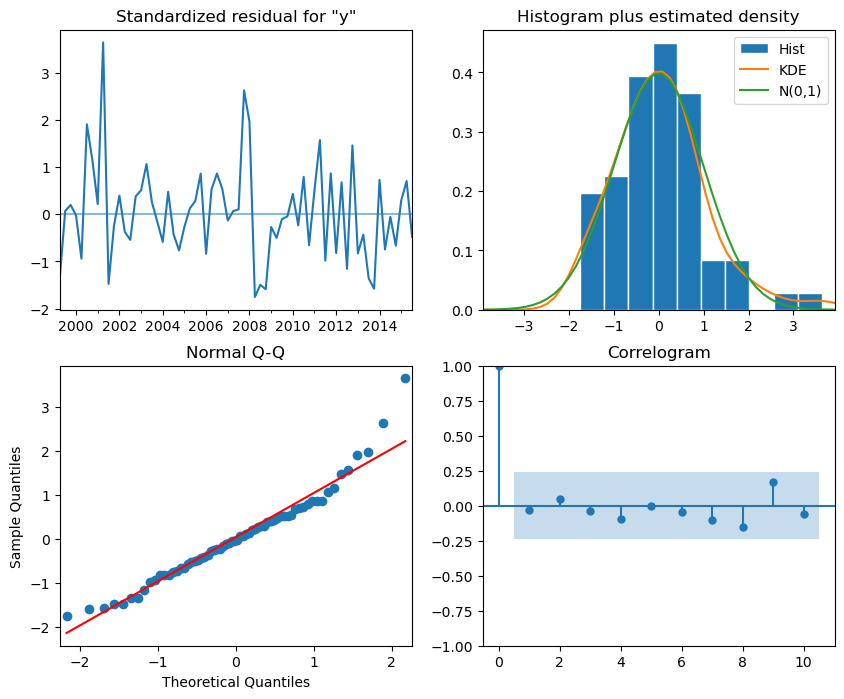

In [13]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

1. **Standardized Residuals**: The top left plot shows the time series of standardized residuals from the model. Ideally, you want no patterns in this plot, which would indicate that the residuals are white noise. In your case, there's no apparent pattern or structure, which is a good sign.

2. **Histogram plus Estimated Density**: The top right plot shows a histogram of standardized residuals, along with an estimated density (the Kernel Density Estimate - KDE), overlaid with a normal distribution (N(0,1)). Your residuals seem to be fairly normally distributed, with some minor deviations, particularly a slight skewness to the left. This is not unusual, but it suggests that the residuals may not be perfectly normally distributed.

3. **Normal Q-Q**: The bottom left plot is a Quantile-Quantile plot. This compares the standardized residuals with a standard normal distribution. Points lying on the red line indicate that the residuals are normally distributed. In your model, there are a few points in the tails that deviate from the line, suggesting some departure from normality in the tails, but overall, the fit is quite good.

4. **Correlogram (ACF plot)**: The bottom right plot shows the autocorrelation of the residuals. For a good model, 95% of correlations for lags greater than zero should not be significant; that is, they should lie within the blue shaded area. In your case, all the dots are within the blue area, which suggests that there is no significant autocorrelation in the residuals.

In [14]:
forecast = model_fit.forecast(steps=9)
print(forecast)

2015Q4    0.003465
2016Q1    0.003629
2016Q2    0.003405
2016Q3    0.003604
2016Q4    0.003652
2017Q1    0.003713
2017Q2    0.003751
2017Q3    0.003780
2017Q4    0.003801
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [16]:
test = test *400
forecast2 = forecast *400

mae_test = mean_absolute_error(test, forecast2)
mae_test

0.4394448206303177

In [17]:
rmse_test = np.sqrt(mean_squared_error(test, forecast2))
rmse_test

0.5296629008004244

In [26]:
test.dtypes

y    float64
dtype: object

In [36]:
test.index = test.index.to_timestamp()

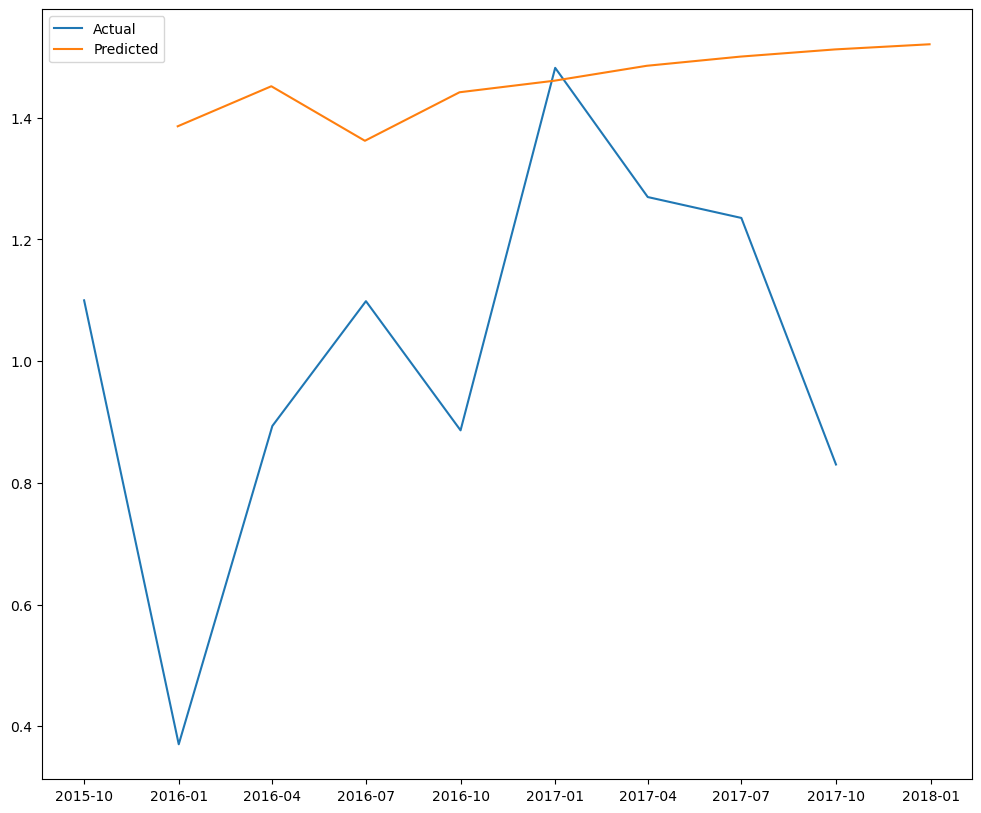

In [30]:
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(test['y'], label='Actual')
plt.plot(forecast2, label='Predicted')
plt.legend()
plt.show()

In [33]:
forecast2

2015Q4    1.385822
2016Q1    1.451606
2016Q2    1.362017
2016Q3    1.441729
2016Q4    1.460661
2017Q1    1.485221
2017Q2    1.500300
2017Q3    1.512127
2017Q4    1.520573
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [37]:
forecast2.index = forecast2.index.to_timestamp()

In [38]:
df = pd.concat([test, forecast2], axis=1)
df

,y,predicted_mean
2015-10-01,1.099841,1.385822
2016-01-01,0.370399,1.451606
2016-04-01,0.893376,1.362017
2016-07-01,1.098487,1.441729
2016-10-01,0.886221,1.460661
2017-01-01,1.481841,1.485221
2017-04-01,1.269561,1.500300
2017-07-01,1.235218,1.512127
2017-10-01,0.830108,1.520573


In [39]:
df = df.rename(columns={'y':'realized', 'predicted_mean':'ARIMA'})
df

,realized,ARIMA
2015-10-01,1.099841,1.385822
2016-01-01,0.370399,1.451606
2016-04-01,0.893376,1.362017
2016-07-01,1.098487,1.441729
2016-10-01,0.886221,1.460661
2017-01-01,1.481841,1.485221
2017-04-01,1.269561,1.500300
2017-07-01,1.235218,1.512127
2017-10-01,0.830108,1.520573


In [40]:
df.to_csv('../data/predictions/ARIMA.csv')